In [114]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import warnings

warnings.simplefilter('ignore')

TRADING_DAYS = 252
TRADING_DAYS_MONTH = TRADING_DAYS // 12
SOFR = 0.0424 # annual sofr rate as of 28/10/2025

In [100]:
def process_data_ticker(ticker: str, features: bool = True) -> pd.DataFrame: # yfinance api is the worst thing ever invented
    ticker = yf.Ticker(ticker).history(period="max")[["Open", "High", "Low", "Close", "Volume"]] # limit to 4 years

    ticker.index = ticker.index.date
    ticker.reset_index(inplace=True)
    ticker.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    return ticker

In [101]:
# For CAPM

def capm() -> None:
    price = yf.Tickers("SAIA ^DJT").history(period="1y")["Close"].rename(columns={"SAIA": "Saia", "^DJT": "Index"})
    returns = price.pct_change().dropna()

    r_market = returns["Index"].mean() * 252
    cov_matrix = returns.cov()
    cov = cov_matrix.iloc[0, 1]
    var = returns["Index"].var()
    beta = cov / var

    print(f"{r_market=}")
    print(f"{beta=}")
    
capm()

[*********************100%***********************]  2 of 2 completed

r_market=-0.007133160525974972
beta=1.69250991350702


In [102]:
data = process_data_ticker("SAIA", False)
price = data[["Date", "Close"]]
price["% Change"] = price.loc[:, "Close"].pct_change()
price.dropna(inplace=True)

print(price.describe())
print(f"Historical CAGR: {100 * (np.prod(price["% Change"]+1) ** (252/price.shape[0]) - 1):.2f}%")
price.head(5)


             Close     % Change
count  5819.000000  5819.000000
mean     92.596540     0.001042
std     131.579464     0.030167
min       4.533333    -0.306561
25%      11.460000    -0.014642
50%      29.660000     0.000795
75%      93.205002     0.016333
max     605.919983     0.197341
Historical CAGR: 15.86%


,Date,Close,% Change
1,2002-09-12,8.913333,-0.077931
2,2002-09-13,8.580000,-0.037397
3,2002-09-16,8.000000,-0.067599
4,2002-09-17,8.166667,0.020833
5,2002-09-18,7.600000,-0.069388


# Goal

Profiles: \
T1M (daily, ideally hourly for simulation but not enough time to do that)\
TTM (daily): volatility most important\
Last 3 yrs (daily)\
Last 5 yrs (daily) \
Each profile: volatility, CAGR, Monte Carlo, Sharpe\
\
Benchmark:\
Compare with stocks from comps and DJT/S&P indices\
project all in monte carlo


In [132]:
class Profile:
    REPR_ROWS = 10
    
    def __init__(self, data: pd.DataFrame, interval: int = 1) -> None:
        self.data = data.drop("% Change", axis="columns")
        self.data.rename(columns={"Close": "Price"}, inplace=True)
        
        self._consolidate(interval)
        self._build()
        
        self.volatility = self.data["Simple Return"].std() * np.sqrt(TRADING_DAYS / interval)
        self.cagr = (self.data["Price"].iloc[-1] / self.data["Price"].iloc[0]) ** (252 / self.data.shape[0]) - 1
        self.sharpe = (self.cagr - SOFR) / self.volatility
        
    def _consolidate(self, interval: int) -> None:
        if interval == 1:
            return
        
        self.data = self.data.iloc[::-interval, :].reset_index(drop=True)
        
    def _build(self) -> None:
        self.data["Simple Return"] = self.data["Price"].pct_change()
        self.data["Log Return"] = np.log(self.data["Price"]).diff()
        
        self.data = self.data.dropna().reset_index(drop=True)
        
    def __repr__(self) -> str:
        return f"Volatility: {self.volatility * 100:.2f}%\nCAGR: {self.cagr * 100:.2f}%\nSharpe Ratio: {self.sharpe:.2f}\n{self.data.tail(self.REPR_ROWS).to_string()}"
    
    def monte_carlo(self, simulations: int = 10_000, period: int = TRADING_DAYS, conf: float = 0.99, plot: bool = True) -> np.ndarray:
        std = self.volatility / np.sqrt(period)
        drift = np.mean(self.data["Log Return"])
        
        paths = np.zeros((simulations, period + 1))
        paths[:, 0] = self.data["Price"].iloc[-1]
        
        daily_log = (drift - 0.5 * std**2) + std * np.random.normal(0, 1, (simulations, period))
        cum_log = np.cumsum(daily_log, axis=1)
        paths[:, 1:] = paths[0, 0] * np.exp(cum_log)
        
        if plot:
            self._plot_monte_carlo(paths, conf)
        
        return paths
    
    def _plot_monte_carlo(self, paths: np.ndarray, conf: float = 0.99) -> None:
        final_prices = paths[:, -1]
        current_price = self.data["Price"].iloc[-1]
        
        # metrics
        mean_final = np.mean(final_prices)
        median_final = np.median(final_prices)
        std_final = np.std(final_prices)
        
        lower_bound = np.percentile(final_prices, 100 * (1 - conf) / 2)
        upper_bound = np.percentile(final_prices, 100 * conf / 2)
        
        returns = (final_prices - current_price) / current_price
        var_total = np.percentile(returns, 100 * (1 - conf)) * 100
        
        prob_profit = np.mean(final_prices > current_price) * 100
        prob_double = np.mean(final_prices > 2 * current_price) * 100
        prob_half = np.mean(final_prices < 0.5 * current_price) * 100
        
        # most probable paths
        median_path = np.median(paths, axis=0)
        
        # Print metrics
        self._print_metrics(current_price, mean_final, median_final, prob_profit,
                        prob_double, prob_half, var_total, lower_bound, upper_bound, conf)
        
        # Create individual figures
        self._plot_simulation_paths(paths, median_path, lower_bound, upper_bound, conf)
        self._plot_final_distribution(final_prices, current_price, mean_final, median_final)
        self._plot_returns_distribution(returns, var_total)

    def _print_metrics(self, current_price, mean_final, median_final, prob_profit,
                    prob_double, prob_half, var_total, lower_bound, upper_bound, conf):
        """Print all metrics to console"""
        print("\n" + "="*60)
        print("MONTE CARLO SIMULATION RESULTS")
        print("="*60)
        print(f"Current Price: ${current_price:.2f}")
        print(f"Expected Final Price: ${mean_final:.2f}")
        print(f"Median Final Price: ${median_final:.2f}")
        print(f"{conf*100:.0f}% Confidence Interval: [${lower_bound:.2f}, ${upper_bound:.2f}]")
        print(f"Probability of Profit: {prob_profit:.1f}%")
        print(f"Probability of > 2x Return: {prob_double:.1f}%")
        print(f"Probability of > 50% Loss: {prob_half:.1f}%")
        print(f"Value at Risk ({conf*100:.0f}%): {var_total:.1f}%")
        print(f"Annual Volatility: {self.volatility*100:.1f}%")
        print(f"CAGR: {self.cagr*100:.1f}%")
        print(f"Sharpe Ratio: {self.sharpe:.2f}")
        print("="*60)

    def _plot_simulation_paths(self, paths, median_path, lower_bound, upper_bound, conf):
        """Plot simulation paths vertically stacked with day-based x-axis"""
        # Create figure with 2 vertical subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        days = paths.shape[1] - 1
        
        # Calculate day ranges (negative for historical, positive for future)
        full_history_days = len(self.data["Price"])
        recent_history_days = min(50, full_history_days)
        
        # Full history: from -full_history_days to days
        full_historical_dates = range(-full_history_days, 0)
        future_dates = range(0, days + 1)
        
        # Recent history: from -recent_history_days to days
        recent_historical_dates = range(-recent_history_days, 0)
        
        # Sample paths for visualization
        n_sample_paths = min(100, paths.shape[0])
        sample_indices = np.random.choice(paths.shape[0], n_sample_paths, replace=False)
        
        # Confidence intervals
        conf_interval_lower = np.percentile(paths, 100 * (1-conf) / 2, axis=0)
        conf_interval_upper = np.percentile(paths, 100 * (1+conf) / 2, axis=0)
        
        # Generate vibrant, varied colors using multiple colormaps
        colors = []
        cmaps = ['plasma', 'viridis', 'inferno', 'rainbow']
        for i in range(n_sample_paths):
            cmap = cmaps[i % len(cmaps)]
            colors.append(plt.cm.get_cmap(cmap)(i / n_sample_paths))
        
        # Plot 1: Full historical data
        ax1.plot(full_historical_dates, self.data["Price"], color="black", linewidth=0.5, label="Historical")
        
        for i, idx in enumerate(sample_indices):
            ax1.plot(future_dates, paths[idx], alpha=0.3, color=colors[i], linewidth=0.3)
        
        ax1.plot(future_dates, median_path, color="red", linewidth=1.5, label="Median Path")
        
        ax1.fill_between(future_dates, conf_interval_lower, conf_interval_upper, alpha=0.2, color="gray", linewidth=0, label=f"{conf*100:.0f}% CI")
        
        # Set x-axis ticks to multiples of 50
        x_min_full = -full_history_days
        x_max_full = days
        x_ticks_full = np.arange((x_min_full // 100) * 100, x_max_full + 1, 100)
        ax1.set_xticks(x_ticks_full)
        
        ax1.set_title("Monte Carlo: Full Historical + Projected", fontsize=12)
        ax1.set_ylabel("Price")
        ax1.legend(fontsize=8)
        ax1.set_xlim(x_min_full, x_max_full)
        
        # Plot 2: Last 50 days only
        recent_prices = self.data["Price"].iloc[-recent_history_days:]
        ax2.plot(recent_historical_dates, recent_prices, color="black", linewidth=0.5, label="Historical (50D)")
        
        for i, idx in enumerate(sample_indices):
            ax2.plot(future_dates, paths[idx], alpha=0.3, color=colors[i], linewidth=0.3)
        
        ax2.plot(future_dates, median_path, color="red", linewidth=1.5, label="Median Path")
        
        ax2.fill_between(future_dates, conf_interval_lower, conf_interval_upper, alpha=0.2, color="gray", linewidth=0, label=f"{conf*100:.0f}% CI")
        
        # Set x-axis ticks to multiples of 50
        x_min_recent = -recent_history_days
        x_max_recent = days
        x_ticks_recent = np.arange((x_min_recent // 50) * 50, x_max_recent + 1, 50)
        ax2.set_xticks(x_ticks_recent)
        
        ax2.set_title("Monte Carlo: 50-Day History + Projected", fontsize=12)
        ax2.set_ylabel("Price")
        ax2.set_xlabel("Days (0 = Today)")
        ax2.legend(fontsize=8)
        ax2.set_xlim(x_min_recent, x_max_recent)
        
        plt.tight_layout()
        plt.show()

    def _plot_final_distribution(self, final_prices, current_price, mean_final, median_final):
        """Plot final price distribution with probability density and vertical lines"""
        plt.figure(figsize=(10, 6))
        
        # Plot KDE for probability density
        kde = gaussian_kde(final_prices)
        x_vals = np.linspace(min(final_prices), max(final_prices), 200)
        y_vals = kde(x_vals)
        
        plt.plot(x_vals, y_vals, color="darkblue", linewidth=0.8)
        
        # Add vertical lines with minimal thickness
        plt.axvline(current_price, color="black", linestyle="-", linewidth=0.8, label="Current Price")
        plt.axvline(mean_final, color="green", linestyle="--", linewidth=0.8, label="Mean")
        plt.axvline(median_final, color="red", linestyle="--", linewidth=0.8, label="Median")
        
        plt.title("Distribution of Final Prices")
        plt.xlabel("Final Price")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()

    def _plot_returns_distribution(self, returns, var_total):
        """Plot returns distribution with probability density and vertical lines"""
        plt.figure(figsize=(10, 6))
        
        returns_pct = returns * 100
        
        # Plot KDE for probability density
        kde = gaussian_kde(returns_pct)
        x_vals = np.linspace(min(returns_pct), max(returns_pct), 200)
        y_vals = kde(x_vals)
        
        plt.plot(x_vals, y_vals, color="darkred", linewidth=0.8)
        
        # Add vertical lines with minimal thickness
        plt.axvline(var_total, color="darkred", linestyle="--", linewidth=0.8, label=f"VaR: {var_total:.1f}%")
        plt.axvline(0, color="black", linestyle="-", linewidth=0.8, label="Break-even")
        
        plt.title("Distribution of Total Returns")
        plt.xlabel("Return (%)")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()

In [ ]:
# note - using daily as gives more data points for accurate monte carlo

t1m = Profile(price.tail(TRADING_DAYS_MONTH))
ttm = Profile(price.tail(TRADING_DAYS))
t3y = Profile(price.tail(TRADING_DAYS * 3))#, TRADING_DAYS_MONTH)
t5y = Profile(price.tail(TRADING_DAYS * 5))#, TRADING_DAYS_MONTH)

profiles = [t1m, ttm, t3y, t5y]

t1m.monte_carlo()
ttm.monte_carlo()
t3y.monte_carlo()
t5y.monte_carlo()
        

# Benchmark

Against peer group
- simple plot of cumulative return

Against indices SPX (S&P500) and DJT (dow jones trucking)

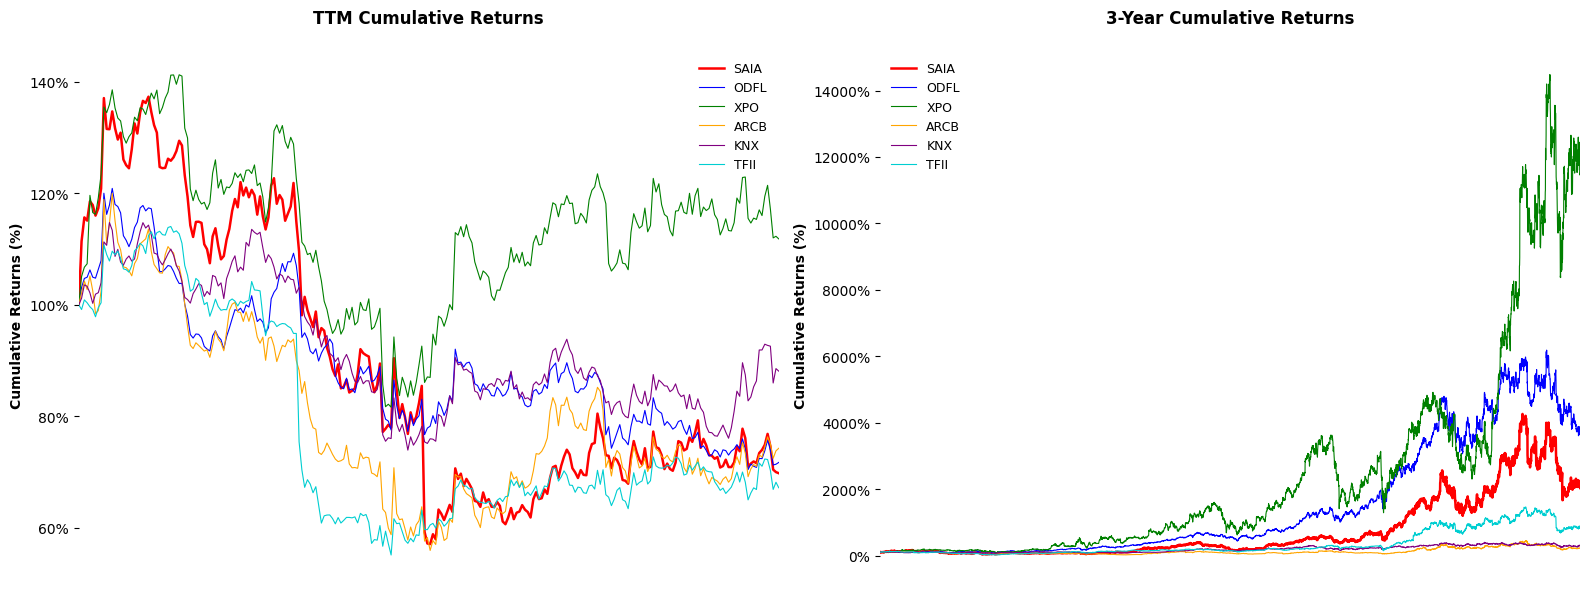


Performance Summary:

TTM Performance:
XPO: +11.82%
KNX: -11.89%
ARCB: -25.72%
ODFL: -28.26%
SAIA: -30.19% ←
TFII: -32.80%

3-Year Performance:
XPO: +11360.36%
ODFL: +3570.77%
SAIA: +1935.55% ←
TFII: +724.02%
KNX: +194.50%
ARCB: +122.86%


In [140]:
from functools import reduce

tickers = ['SAIA', 'ODFL', 'XPO', 'ARCB', 'KNX', 'TFII']

price_dfs = []
for ticker in tickers:
    data = process_data_ticker(ticker, False)
    price_data = data[["Date", "Close"]].copy()
    price_data.rename(columns={"Close": ticker}, inplace=True)
    price_dfs.append(price_data)

# Merge all DataFrames using reduce
combined_prices = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), price_dfs)
peers = combined_prices.sort_values("Date").reset_index(drop=True)

def visualize_saia_benchmark(price_df):
    """
    Visualize SAIA against peers for TTM and 3-year periods
    
    Parameters:
    price_df: DataFrame with tickers as columns and 252*3 rows of prices
    """
    # Ensure we have the required tickers
    required_tickers = ['SAIA', 'ODFL', 'XPO', 'ARCB', 'KNX', 'TFII']
    missing_tickers = [ticker for ticker in required_tickers if ticker not in price_df.columns]
    
    if missing_tickers:
        print(f"Warning: Missing tickers in dataframe: {missing_tickers}")
        available_tickers = [ticker for ticker in required_tickers if ticker in price_df.columns]
    else:
        available_tickers = required_tickers
    
    # Calculate cumulative returns
    # For 3-year: normalize to the very first value (index 0)
    three_year_returns = price_df[available_tickers].div(price_df[available_tickers].iloc[0])
    
    # For TTM: normalize to the value at the start of TTM period (252 days ago from end)
    ttm_start_idx = -252  # Start of TTM period (252 trading days from end)
    ttm_prices = price_df[available_tickers].iloc[ttm_start_idx:]
    ttm_returns = ttm_prices.div(ttm_prices.iloc[0])
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # More distinct primary colors
    colors = ['#FF0000', '#0000FF', '#008000', '#FFA500', '#800080', '#00CED1']  # Red, Blue, Green, Orange, Purple, Cyan
    
    # Plot TTM cumulative returns
    for i, ticker in enumerate(available_tickers):
        if ticker in ttm_returns.columns:
            linewidth = 1.8 if ticker == 'SAIA' else 0.8
            color_idx = required_tickers.index(ticker) if ticker in required_tickers else i
            ax1.plot(ttm_returns[ticker].values, 
                    label=ticker, color=colors[color_idx], linewidth=linewidth)
    
    ax1.set_title('TTM Cumulative Returns', fontweight='bold', pad=20, size=12)
    ax1.legend(fontsize=9, frameon=False)
    
    # Plot 3-year cumulative returns
    for i, ticker in enumerate(available_tickers):
        if ticker in three_year_returns.columns:
            linewidth = 1.8 if ticker == 'SAIA' else 0.8
            color_idx = required_tickers.index(ticker) if ticker in required_tickers else i
            ax2.plot(three_year_returns[ticker].values, 
                    label=ticker, color=colors[color_idx], linewidth=linewidth)
    
    ax2.set_title('3-Year Cumulative Returns', fontweight='bold', pad=20, size=12)
    ax2.legend(fontsize=9, frameon=False)
    
    # Remove gridlines and adjust layout for both subplots
    for ax in [ax1, ax2]:
        ax.grid(False)
        # Remove all spines (borders)
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
        
        # Set y-axis label as percentage
        ax.set_ylabel('Cumulative Returns (%)', fontweight='bold', size=10)
        
        # Convert y-axis to percentage format
        from matplotlib.ticker import PercentFormatter
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        
        # Remove x-axis entirely
        ax.set_xticks([])
        ax.set_xlabel('')
        
        # Remove whitespace by setting tight x-axis limits
        ax.set_xlim(0, len(ax.lines[0].get_ydata())-1 if ax.lines else 0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()
    
    # Print performance summary
    print("\nPerformance Summary:")
    print("="*50)
    
    for period_name, returns_df in [("TTM", ttm_returns), ("3-Year", three_year_returns)]:
        print(f"\n{period_name} Performance:")
        performances = {}
        
        for ticker in available_tickers:
            if ticker in returns_df.columns and len(returns_df[ticker]) > 0:
                total_return = (returns_df[ticker].iloc[-1] - 1) * 100
                performances[ticker] = total_return
        
        # Sort by performance
        sorted_perf = sorted(performances.items(), key=lambda x: x[1], reverse=True)
        
        for ticker, perf in sorted_perf:
            highlight = " ←" if ticker == 'SAIA' else ""
            print(f"{ticker}: {perf:+.2f}%{highlight}")



visualize_saia_benchmark(peers)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-10-21   2022-10-21
End Period                 2025-10-27   2025-10-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          23.4%        52.88%
CAGR﹪                     4.93%        10.19%

Sharpe                     0.43         0.54
Prob. Sharpe Ratio         77.29%       82.05%
Smart Sharpe               0.42         0.53
Sortino                    0.64         0.75
Smart Sortino              0.62         0.74
Sortino/√2                 0.45         0.53
Smart Sortino/√2           0.44         0.52
Omega                      1.11         1.11

Max Drawdown               -28.82%      -60.94%
Longest DD Days            464          600
Volatility (ann.)          21.76%       52.39%
R^2                        0.41         0.41
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-03-07,2025-04-29,2025-10-27,600,-60.943689,-58.504423
2,2023-09-05,2023-10-27,2023-12-20,107,-21.505764,-18.543935
3,2022-11-16,2022-12-28,2023-01-26,72,-20.413622,-20.253066
4,2023-02-08,2023-04-26,2023-04-27,79,-16.204439,-14.167484
5,2023-05-01,2023-05-16,2023-06-01,32,-9.050604,-8.177444


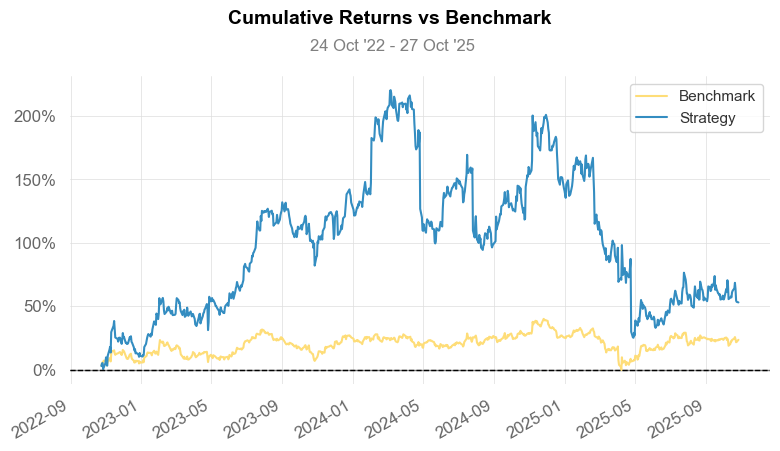

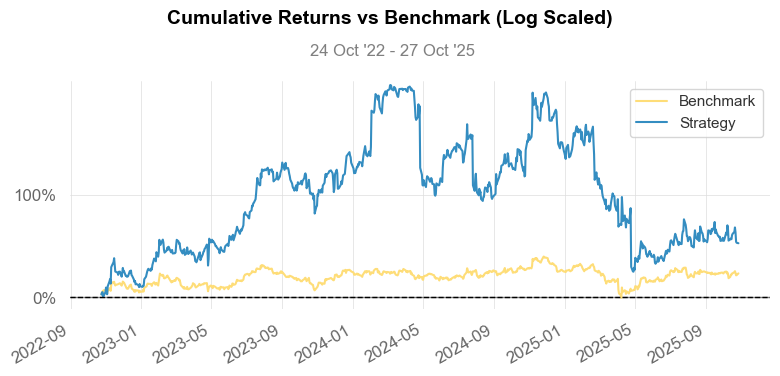

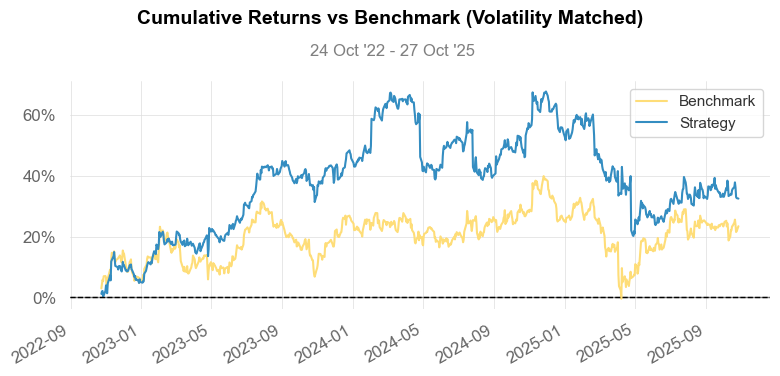

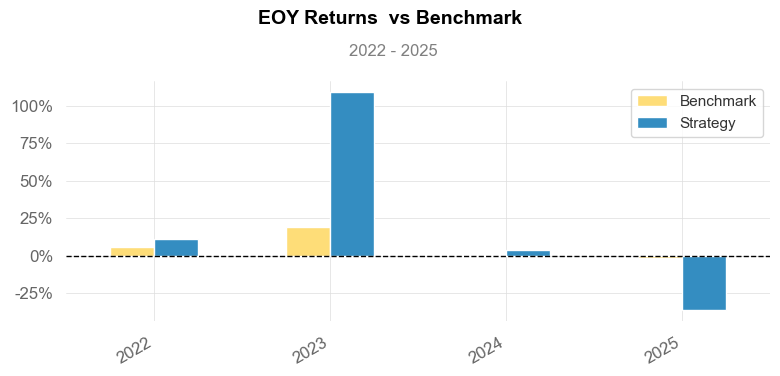

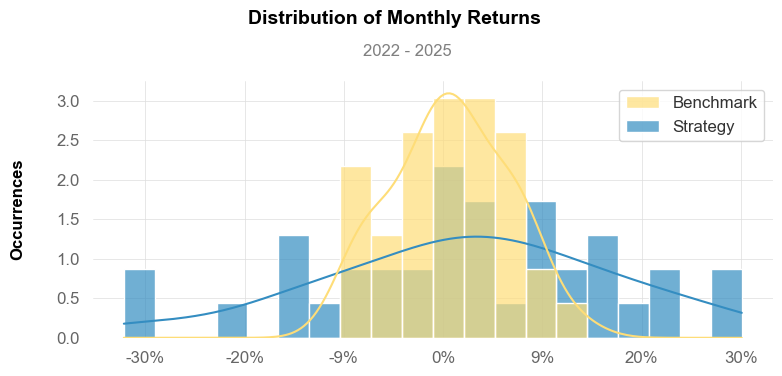

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-10-24   2024-10-24
End Period                 2025-10-27   2025-10-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -2.57%       -30.19%
CAGR﹪                     -1.77%       -21.81%

Sharpe                     0.02         -0.26
Prob. Sharpe Ratio         50.96%       39.79%
Smart Sharpe               0.02         -0.24
Sortino                    0.04         -0.34
Smart Sortino              0.03         -0.32
Sortino/√2                 0.03         -0.24
Smart Sortino/√2           0.02         -0.23
Omega                      0.95         0.95

Max Drawdown               -28.82%      -58.42%
Longest DD Days            336          330
Volatility (ann.)          25.51%       61.8%
R^2                        0.49         0.49
Information Ratio          -0.02        -0.02
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2025-04-29,2025-10-27,330,-58.415339,-57.123780
2,2024-11-07,2024-11-19,2024-11-27,21,-9.179257,-8.776106
3,2024-10-31,2024-11-01,2024-11-04,5,-2.165547,-1.056311
4,2024-10-29,2024-10-29,2024-10-29,1,-0.498564,NaN


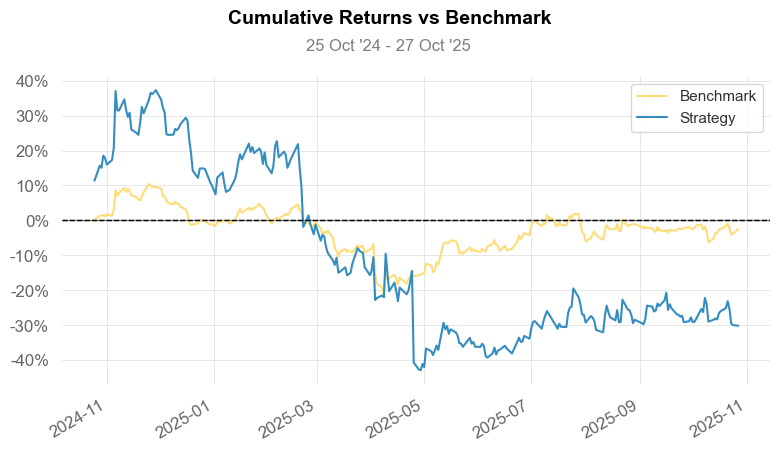

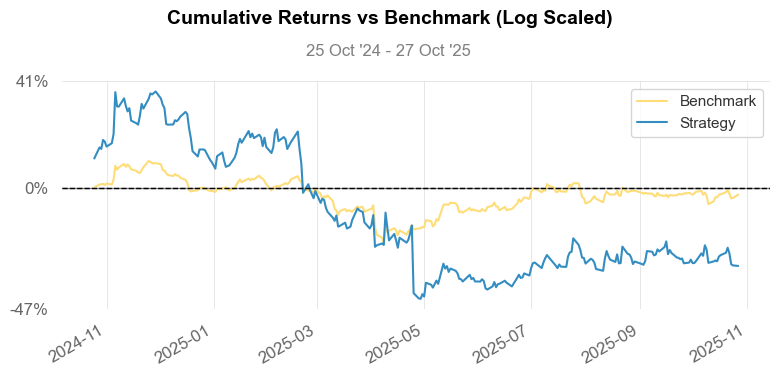

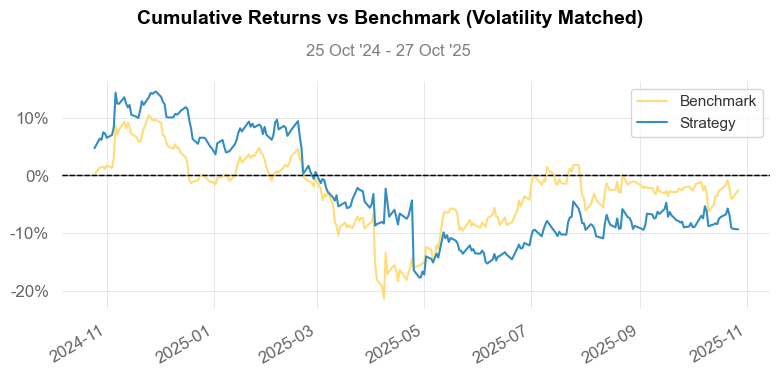

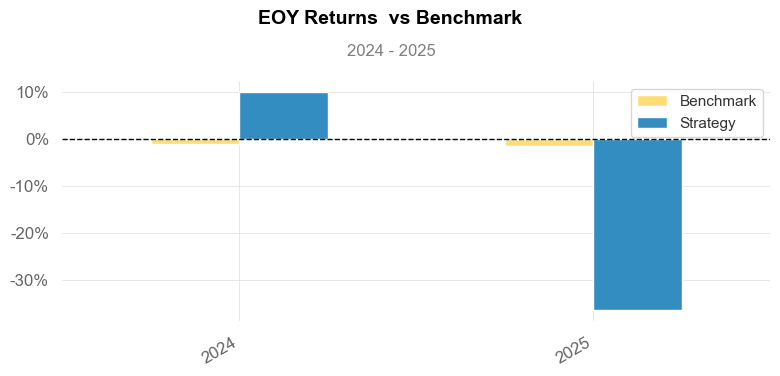

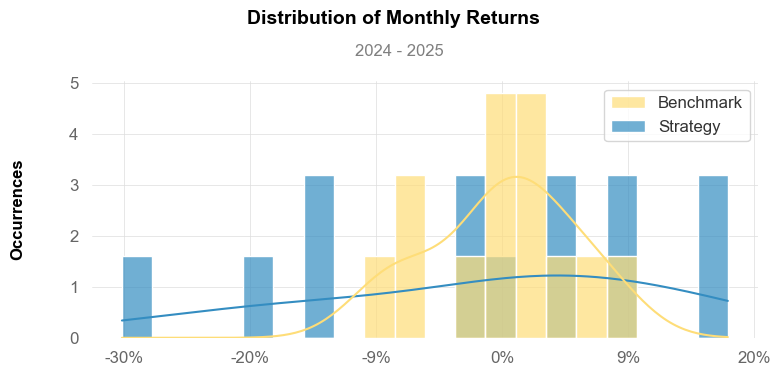

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-10-21   2022-10-21
End Period                 2025-10-27   2025-10-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          83.2%        52.88%
CAGR﹪                     14.85%       10.19%

Sharpe                     1.35         0.54
Prob. Sharpe Ratio         99.14%       82.05%
Smart Sharpe               1.32         0.53
Sortino                    2.05         0.75
Smart Sortino              2.01         0.74
Sortino/√2                 1.45         0.53
Smart Sortino/√2           1.42         0.52
Omega                      1.11         1.11

Max Drawdown               -18.9%       -60.94%
Longest DD Days            127          600
Volatility (ann.)          15.86%       52.39%
R^2                        0.19         0.19
Information Ratio          0.01         0.01
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-03-07,2025-04-29,2025-10-27,600,-60.943689,-58.504423
2,2023-09-05,2023-10-27,2023-12-20,107,-21.505764,-18.543935
3,2022-11-16,2022-12-28,2023-01-26,72,-20.413622,-20.253066
4,2023-02-08,2023-04-26,2023-04-27,79,-16.204439,-14.167484
5,2023-05-01,2023-05-16,2023-06-01,32,-9.050604,-8.177444


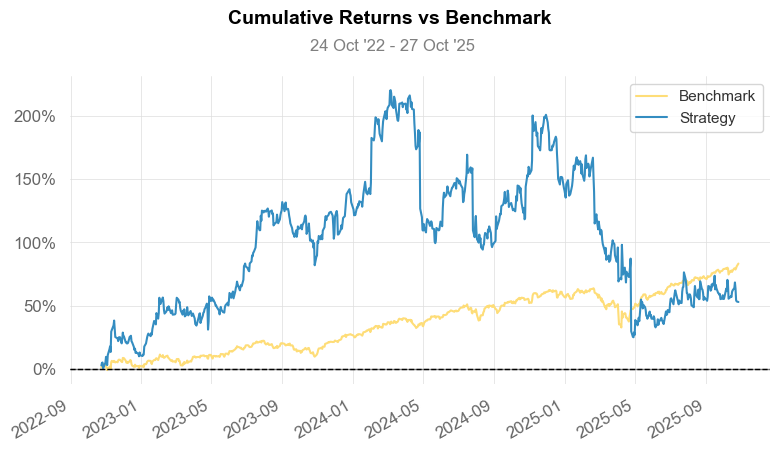

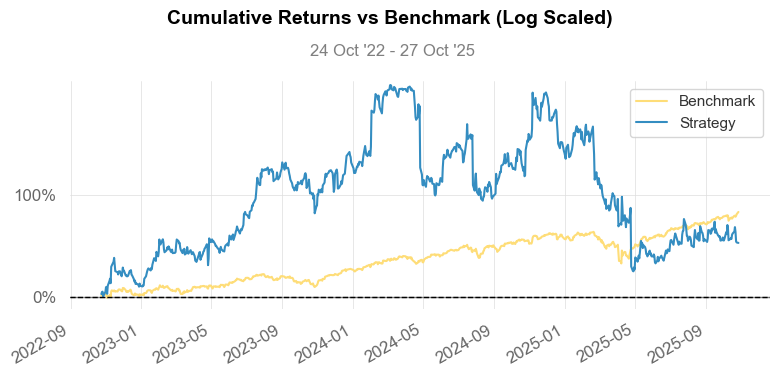

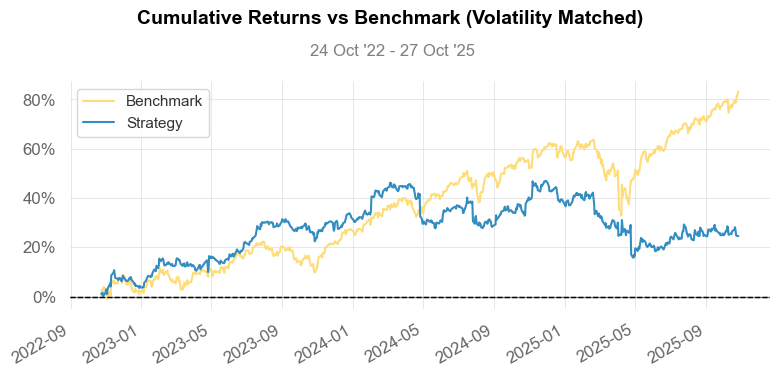

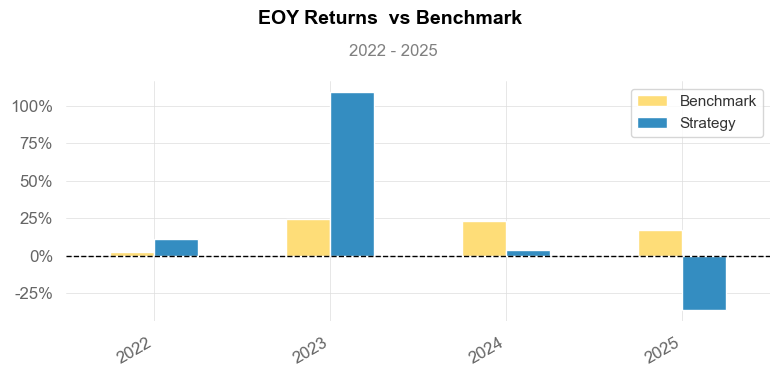

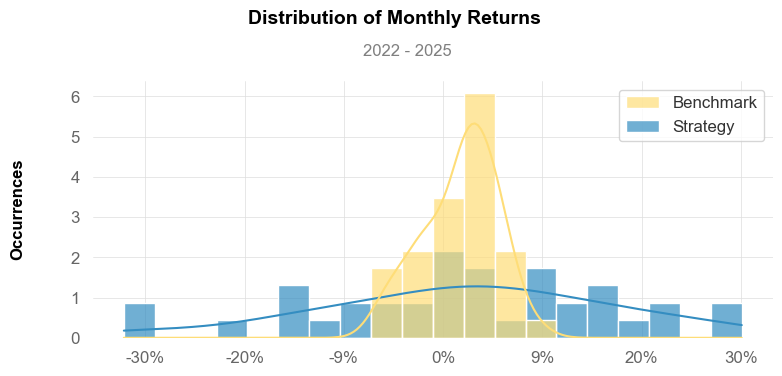

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-10-24   2024-10-24
End Period                 2025-10-27   2025-10-27
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          18.34%       -30.19%
CAGR﹪                     12.22%       -21.81%

Sharpe                     0.98         -0.26
Prob. Sharpe Ratio         84.27%       39.79%
Smart Sharpe               0.92         -0.24
Sortino                    1.46         -0.34
Smart Sortino              1.36         -0.32
Sortino/√2                 1.03         -0.24
Smart Sortino/√2           0.96         -0.23
Omega                      0.95         0.95

Max Drawdown               -18.9%       -58.42%
Longest DD Days            127          330
Volatility (ann.)          18.89%       61.8%
R^2                        0.23         0.23
Information Ratio          -0.04        -0.04
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2025-04-29,2025-10-27,330,-58.415339,-57.123780
2,2024-11-07,2024-11-19,2024-11-27,21,-9.179257,-8.776106
3,2024-10-31,2024-11-01,2024-11-04,5,-2.165547,-1.056311
4,2024-10-29,2024-10-29,2024-10-29,1,-0.498564,NaN


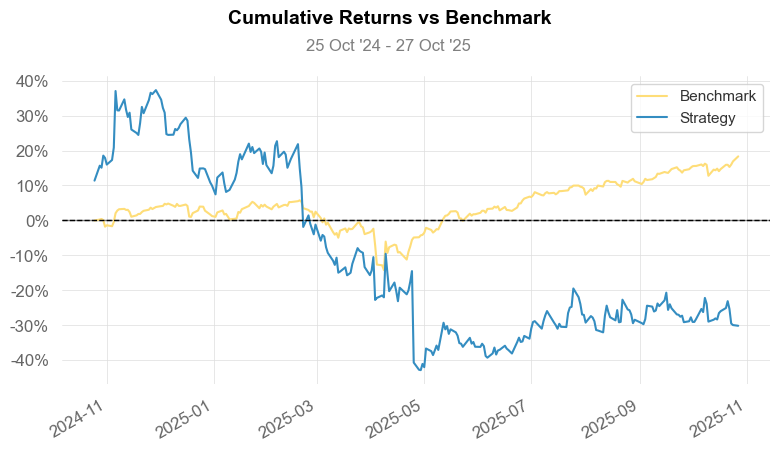

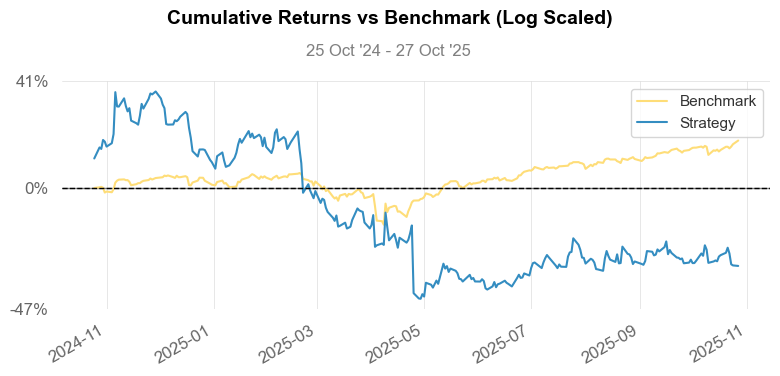

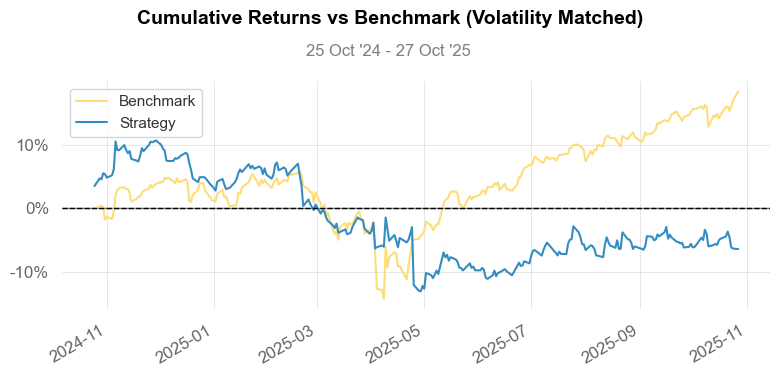

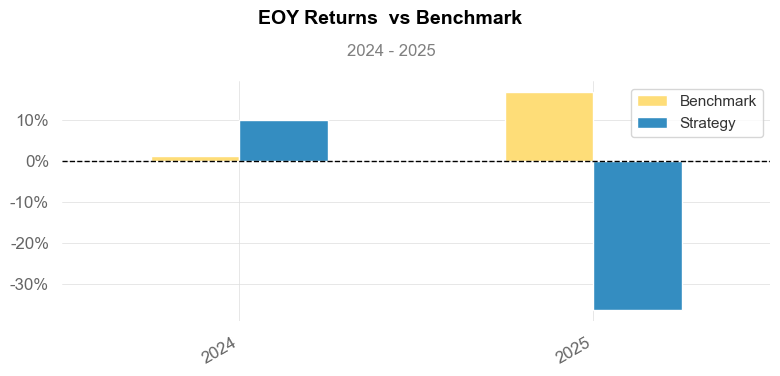

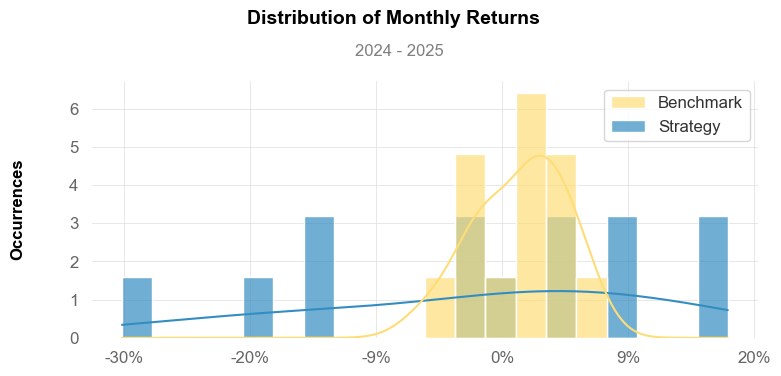

In [176]:
import quantstats as qs

saia = process_data_ticker("SAIA", False)[["Date", "Close"]].tail(TRADING_DAYS * 3 + 1)
djt = process_data_ticker("^DJT", False)[["Date", "Close"]].tail(TRADING_DAYS * 3)
spx = process_data_ticker("^GSPC", False)[["Date", "Close"]].tail(TRADING_DAYS * 3)


for i in [saia, djt, spx]:
    i.set_index(pd.to_datetime(i["Date"]), inplace=True)

a = pd.concat([saia["Close"], djt["Close"], spx["Close"]], axis=1)
a.columns = ["SAIA", "DJT", "SPX"]
a.dropna(inplace=True)
b = a.tail(TRADING_DAYS)

try:
    qs.reports.full(a["SAIA"], a["DJT"], match_dates=False)
except: pass
try:
    qs.reports.full(b["SAIA"], b["DJT"], match_dates=False)
except: pass

try:
    qs.reports.full(a["SAIA"], a["SPX"], match_dates=False)
except: pass
try:
    qs.reports.full(b["SAIA"], b["SPX"], match_dates=False)
except: pass




